## Trying out various examples in Tensorflow Probability

```tfp.distributions.MixtureSameFaily```

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from utils import *

In [ ]:
import tensorflow_probability as tfp

In [ ]:
tfd = tfp.distributions

In [ ]:
gm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[0.3, 0.7]),
    components_distribution=tfd.Normal(
        loc=[-1., 1.],     # One for each component.
        scale=[0.1, 0.5])) # and same here.

gm.mean()

gm.variance()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

x = np.linspace(-2., 3., int(1e4), dtype=np.float32)
plt.plot(x, gm.prob(x).eval());

Create a mixture of two Bivariate Gaussians:

In [ ]:
gm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[0.3, 0.7]),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=[[-1., 1],  # component 1
             [1, -1]],  # component 2
        scale_identity_multiplier=[.3, .6]))

gm.mean()

gm.covariance()

In [ ]:
def meshgrid(x, y=x):
    [gx, gy] = np.meshgrid(x, y, indexing='ij')
    gx, gy = np.float32(gx), np.float32(gy)
    grid = np.concatenate([gx.ravel()[None, :], gy.ravel()[None, :]], axis=0)
    return grid.T.reshape(x.size, y.size, 2)

In [ ]:
grid = meshgrid(np.linspace(-2, 2, 100, dtype=np.float32))
plt.contour(grid[..., 0], grid[..., 1], gm.prob(grid).eval());

### Hamiltonian Monte Carlo (HMC)
It takes a series of gradient-informed steps to produce a Metropolis proposal.

In [ ]:
# Target distribution is proportional to `exp(-x(1+x))`.
def unnormalized_log_prob(x):
    return -x - x**2

In [ ]:
# Initialize the HMC transition kernel.
num_results = int(10e3)
num_burnin_steps = int(10e3)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

In [ ]:
# Run the chain (with burn-in)
@tf.function
def run_chain():
    # Run the chain
    samples, is_accepted = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=1,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
    
    sample_mean = tf.reduce_mean(samples)
    sample_stddev = tf.math.reduce_std(samples)
    is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
    return sample_mean, sample_stddev, is_accepted


In [ ]:
sample_mean, sample_stddev, is_accepted = run_chain()

print('mean:{:.4f} stddev:{:.4f} acceptance:{:.4f}'.format(
    sample_mean.numpy(), sample_stddev.numpy(), is_accepted.numpy()))

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

tf.enable_eager_execution()

# Target distribution is proportional to: `exp(-x (1 + x))`.
def unnormalized_log_prob(x):
    return -x - x**2.

# Initialize the HMC transition kernel.
num_results = int(10e3)
num_burnin_steps = int(1e3)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Run the chain (with burn-in).
@tf.function
def run_chain():
    # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=1.,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

    sample_mean = tf.reduce_mean(samples)
    sample_stddev = tf.math.reduce_std(samples)
    is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
    return sample_mean, sample_stddev, is_accepted

sample_mean, sample_stddev, is_accepted = run_chain()

print('mean:{:.4f}  stddev:{:.4f}  acceptance:{:.4f}'.format(
    sample_mean.numpy(), sample_stddev.numpy(), is_accepted.numpy()))

/Users/sueliu/projects/personal-study/Bayesian-Methods-for-Hackers/.venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/sueliu/projects/personal-study/Bayesian-Methods-for-Hackers/.venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/sueliu/projects/personal-study/Bayesian-Methods-for-Hackers/.venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,

mean:-0.4989  stddev:0.7302  acceptance:0.7860


### Estimate parameters of a more complicated posterior.

In this example, we'll use Monte-Carlo EM to find best-fit parameters.

More precisely, we use HMC to form a chain conditioned on parameter `sigma` and training data `{ (x[i], y[i]) : i=1...n}` Then we use one gradient step of maximum-likelihood to improve `sigma` estimate. Then repeat the process until convergence. This procedure is a Robbins-Monro algorithm.

The generative assumptions are:
```
W ~ MVN(loc=0, scale=sigma * eye(dims))
for i=1...num_samples:
    X[i] ~ MVN(loc=0, scale=eye(dims))
    eps[i] ~ Normal(loc=0, scale=1)
    Y[i] = X[i].T * W + eps[i]
```

We now implement a stochastic approximation of Expectation maximation (SAEM) using `tensorflow_probability` intrinsics.

In [2]:
import tensorflow as tf
import numpy as np

tfd = tfp.distributions

In [4]:
def make_training_data(num_samples, dims, sigma):
    dt = np.asarray(sigma).dtype
    x = np.random.randn(dims, num_samples).astype(dt)
    w = sigma * np.random.randn(1, dims).astype(dt)
    noise = np.random.randn(num_samples).astype(dt)
    y = w.dot(x) + noise
    return y[0], x, w[0]

In [5]:
def make_weights_prior(dims, log_sigma):
    return tfd.MultivariateNormalDiag(
        loc=tf.zeros([dims], dtype=log_sigma.dtype),
        scale_identity_multiplier=tf.exp(log_sigma))

In [6]:
def make_response_likelihood(w, x):
    if w.shape.ndims == 1:
        y_bar = tf.matmul(w[tf.newaxis], x)[0]
    else:
        y_bar = tf.matmul(w, x)
    return tfd.Normal(loc=y_bar, scale=tf.ones_like(y_bar))

In [7]:
dtype = np.float32
num_samples = 500
dims = 10
tf.compat.v1.random.set_random_seed(10014)
np.random.seed(10014)

weights_prior_true_scale = np.array(0.3, dtype)
y, x, _ = make_training_data(
    num_samples, dims, weights_prior_true_scale)

log_sigma = tf.compat.v2.Variable(
    name='log_sigma', initial_value=np.array(0, dtype))

optimizer = tf.compat.v2.optimizers.SGD(learning_rate=0.01)

In [8]:
@tf.function
def mcem_iter(weights_chain_start, step_size):
    with tf.GradientTape() as tape:
        tape.watch(log_sigma)
        prior = make_weights_prior(dims, log_sigma)
        
        def unnormalized_posterior_log_prob(w):
            likelihood = make_response_likelihood(w, x)
            return (
                prior.log_prob(w) +
                tf.reduce_sum(
                    input_tensor=likelihood.log_prob(y), axis=-1))
        
        def trace_fn(_, pkr):
            return (
                pkr.inner_results.log_accept_ratio,
                pkr.inner_results.accepted_results.target_log_prob,
                pkr.inner_results.accepted_results.step_size
            )
        num_results = 2
        weights, (
            log_accept_ratio, target_log_prob, step_size) = tfp.mcmc.sample_chain(
            num_results=num_results,
            num_burnin_steps=0,
            current_state=weights_chain_start,
            kernel=tfp.mcmc.SimpleStepSizeAdaptation(
                tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn=unnormalized_posterior_log_prob,
                    num_leapfrog_steps=2,
                    step_size=step_size,
                    state_gradients_are_stopped=True,
                ),
                # Adapt for the entirety of the trajectory.
                num_adaptation_steps=2),
            trace_fn=trace_fn,
            parallel_iterations=1)
        
        # We do an optimization step to propagate `log_sigma` after two HMC 
        # steps to propagate `weights`.
        loss = -tf.reduce_mean(input_tensor=target_log_prob)
        
    avg_acceptance_ratio = tf.reduce_mean(
        input_tensor=tf.exp(tf.minimum(log_accept_ratio, 0.)))
    
    optimizer.apply_gradients(
        [[tape.gradient(loss, log_sigma), log_sigma]])
    
    weights_prior_estimated_scale = tf.exp(log_sigma)
    return (weights_prior_estimated_scale, weights[-1], loss,
           step_size[-1], avg_acceptance_ratio)

In [9]:
num_iters = int(40)

weights_prior_estimated_scale_ = np.zeros(num_iters, dtype)
weights_ = np.zeros([num_iters + 1, dims], dtype)
loss_ = np.zeros([num_iters], dtype)
weights_[0] = np.random.randn(dims).astype(dtype)
step_size_ = 0.03

for iter_ in range(num_iters):
    [
        weights_prior_estimated_scale_[iter_],
        weights_[iter_ + 1],
        loss_[iter_],
        step_size_,
        avg_acceptance_ratio_,
    ] = mcem_iter(weights_[iter_], step_size_)
    tf.compat.v1.logging.vlog(
        1, ('iter:{:>2} loss:{:9.3f} scale:{:.3f}  '
           'step_size: {:.4f} avg_acceptance_ratio:{:.4f}').format(
            iter_, loss_[iter_], weights_prior_estimated_scale_[iter_],
            step_size_, avg_acceptance_ratio_))

In [11]:
%matplotlib inline

Text(0.5, 0, 'iteration')

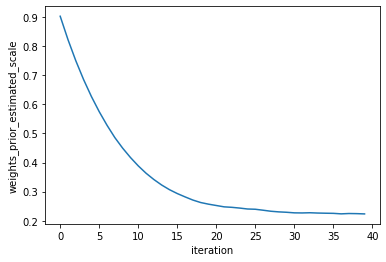

In [12]:
import matplotlib.pyplot as plt
plt.plot(weights_prior_estimated_scale_)
plt.ylabel('weights_prior_estimated_scale')
plt.xlabel('iteration')

In [14]:
tfp.mcmc.TransformedTransitionKernel?

## `SimpleStepSizeAdaptation`